In [1]:
import sys

sys.path.append("../")
sys.path.append("../cpp/build")

In [16]:
from utils import open_pickle
from utils import check_solution
from cube3_game import Cube3Game
import cpp_a_star

import numpy as np

from tqdm import tqdm
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

In [3]:
optimum = open_pickle("../assets/data/deepcubea/data_0.pkl")
deepcube_res = open_pickle("../assets/data/deepcubea/results.pkl")
report = open_pickle("../assets/reports/result_cb_on_deepcube.pickle")

In [4]:
game = Cube3Game("../assets/envs/qtm_cube3.pickle")
cpp_a_star.init_envs(game.actions)

set_actions; action_size: 12; space_size: 54


In [5]:
for i in range(len(report["states"])):
    optim_solution = optimum["solutions"][i]
    optim_solution = [game.tuple_to_id(s) for s in optim_solution]

    m_solution = report["solutions"][i]
    
    state = np.array(report["states"][i])
    if len(m_solution) > len(optim_solution) + 3:
        print("i", i)
        print(f"opt ({len(optim_solution)}):       ", optim_solution)
        print(f"m_solution ({len(m_solution)}):", m_solution)
        break

i 7
opt (20):        [6, 5, 4, 1, 2, 5, 8, 11, 11, 0, 5, 9, 9, 1, 11, 1, 3, 4, 1, 9]
m_solution (24): [3, 10, 2, 10, 1, 11, 4, 2, 10, 6, 4, 6, 6, 9, 6, 3, 10, 5, 7, 8, 3, 11, 3, 5]


In [9]:
model = CatBoostRegressor()
model.load_model("../assets/models/catboost_cube3.cb")

In [70]:
state = np.array(report["states"][i])
optmi_hs = []
for action in optim_solution:
    h = model.predict(state)
    optmi_hs.append(h)
    state = game.apply_action(state, action)
h = model.predict(state)
optmi_hs.append(h)

    # break

# state = np.array(report["states"][i])
# m_hs = []
# for action in m_solution:
#     h = model.predict(state)
#     m_hs.append(h)
#     state = game.apply_action(state, action)
#     # break

In [72]:
len(optmi_hs)

21

In [69]:
len(optim_solution)

20

In [46]:
state = np.array(report["states"][i])
h_values = {}
for beam_size in tqdm([100, 1_000, 10_000, 100_000, 1_000_000, 10_000_000]):
    result = cpp_a_star.catboost_parallel_search_a(
        state, # state
        10_000_000, # limit size
        False, # debug,
        10, # parallel_size,
        beam_size, # open_max_size
        1.0 # alpha
    )
    h_values[beam_size] = result.h_values

100%|██████████| 6/6 [06:48<00:00, 68.10s/it] 


In [42]:
int(np.log10(1_000_001))

6

In [47]:
def to_human(v):
    d = int(np.log10(v))
    if d > 5:
        return str(int(v/(10**6))) + "M"
    elif d > 2:
        return str(int(v/(10**3))) + "K"
    else:
        return str(v)

Text(0.5, 1.0, 'A* + open queue size limit')

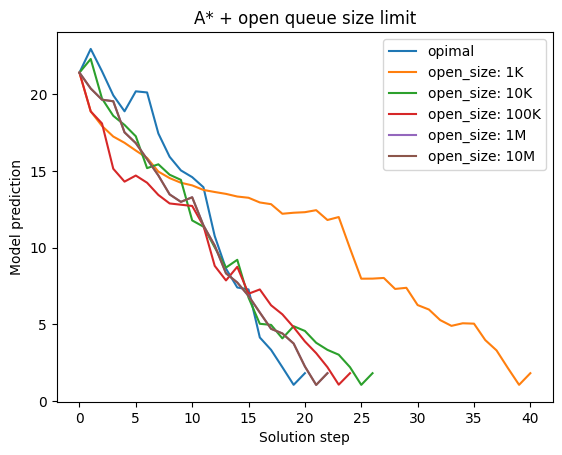

In [82]:
plt.plot(optmi_hs)
for solution in list(h_values.values())[1:]:
    plt.plot(solution)

plt.legend(["opimal"] + [f"open_size: {to_human(beam_size)}" for beam_size in h_values.keys()][1:])
plt.xlabel("Solution step")
plt.ylabel("Model prediction")
plt.title("A* + open queue size limit")

In [66]:
[len(v) for v in h_values.values()]

[95, 41, 27, 25, 23, 23]

In [80]:
print(h_values[10_000_000])
print(h_values[1_000_000])

[21.40508460998535, 20.368640899658203, 19.639562606811523, 19.53775405883789, 17.509851455688477, 16.80698013305664, 15.761924743652344, 14.700349807739258, 13.46342945098877, 12.977160453796387, 13.276369094848633, 11.437875747680664, 10.126443862915039, 8.317302703857422, 7.7179412841796875, 6.843832492828369, 5.761111736297607, 4.697202205657959, 4.3974928855896, 3.7385950088500977, 2.242546796798706, 1.0390170812606812, 1.8039040565490723]
[21.40508460998535, 20.368640899658203, 19.639562606811523, 19.53775405883789, 17.509851455688477, 16.80698013305664, 15.761924743652344, 14.700349807739258, 13.46342945098877, 12.977160453796387, 13.276369094848633, 11.437875747680664, 10.126443862915039, 8.317302703857422, 7.7179412841796875, 6.843832492828369, 5.761111736297607, 4.697202205657959, 4.3974928855896, 3.7385950088500977, 2.242546796798706, 1.0390170812606812, 1.8039040565490723]


In [6]:
# state = np.array(report["states"][i])
# state = game.apply_action(state, 6)
# while not game.is_goal(state):
#     child_sol_lengths = []
#     for action in tqdm(range(game.action_size)):
#         child_state = game.apply_action(state, action)
#         result = cpp_a_star.catboost_parallel_search_a(
#             child_state, # state
#             10_000_000, # limit size
#             False, # debug,
#             10, # parallel_size,
#             1000, # open_max_size
#             1.0 # alpha
#         )
#         s_l = len(result.actions)
#         child_sol_lengths.append(s_l)

#     # print(probs)
#     next_action = np.argmin(child_sol_lengths)
#     print("choose action", next_action)
#     state = game.apply_action(state, next_action)    